In [179]:
import sys

In [180]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [181]:
FEATURE_ID = 465

In [182]:
CONVERTED_DATABASE_NAME = '/home/ubuntu/UPS2_DIA_180907/UPS2_DIA_180907.sqlite'
SUMMED_REGIONS_DATABASE = '/home/ubuntu/UPS2_DIA_180907/UPS2_DIA_180907-features-{}-{}.sqlite'.format(FEATURE_ID, FEATURE_ID)

In [183]:
def standard_deviation(mz):
    instrument_resolution = 40000.0
    return ((mz / instrument_resolution) / 2.35482)

In [184]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
feature_df = pd.read_sql_query("select * from feature_list where feature_id = {}".format(FEATURE_ID), db_conn)
db_conn.close()

In [185]:
feature_df

,feature_id,charge_state,monoisotopic_mass,base_peak_centroid_scan,base_peak_centroid_rt,base_peak_id,isotope_count,cluster_mz_centroid,cluster_summed_intensity,start_frame,end_frame,scan_lower,scan_upper,minimum_error,minimum_error_sulphur
0,465,3,2284.627173,422.138669,1050.12575,1,5,762.549667,1723960,3744,3757,392,455,0.469393,2


In [186]:
charge_state = feature_df.iloc[0].charge_state

In [187]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
peaks_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id = {} order by peak_id".format(FEATURE_ID), db_conn)
db_conn.close()

In [188]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

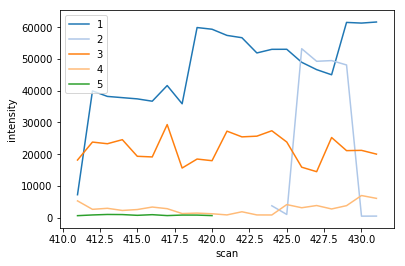

In [189]:
fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.plot(group.scan, group.intensity, color=tableau20[i], label=name)
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

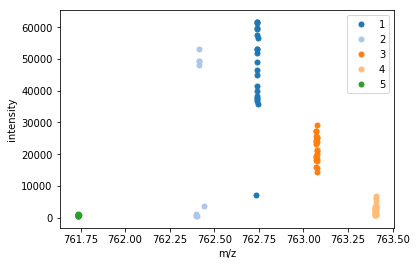

In [190]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.plot(group.mz, group.intensity, marker='o', color=tableau20[i], linestyle='', ms=5, label=name)
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

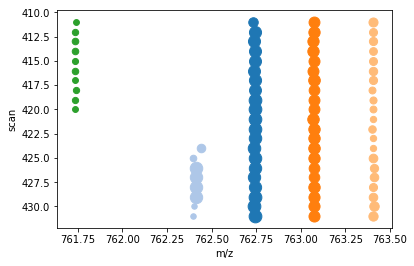

In [191]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    for data_point in group.itertuples():
        markersize = 10+1.5*np.log(data_point.intensity*0.0001)
        ax.plot(data_point.mz, data_point.scan, marker='o', color=tableau20[i], linestyle='', markersize=markersize, label=name)
# plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
plt.margins(0.06)
plt.show()

In [192]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [193]:
mzs = peaks_df.groupby('peak_id').apply(wavg, "mz", "intensity").reset_index(name='mz_centroid')

In [194]:
mzs

,peak_id,mz_centroid
0,1,762.741328
1,2,762.413247
2,3,763.073055
3,4,763.405291
4,5,761.736027


In [195]:
intensities = peaks_df.groupby('peak_id').intensity.sum().reset_index(name='summed_intensity')

In [196]:
intensities

,peak_id,summed_intensity
0,1,991466
1,2,205885
2,3,457446
3,4,61030
4,5,8133


In [197]:
cluster_df = pd.concat([mzs, intensities.summed_intensity], axis=1)

In [198]:
cluster_df

,peak_id,mz_centroid,summed_intensity
0,1,762.741328,991466
1,2,762.413247,205885
2,3,763.073055,457446
3,4,763.405291,61030
4,5,761.736027,8133


In [199]:
cluster_df.sort_values(by='mz_centroid', inplace=True)

In [200]:
cluster_df

,peak_id,mz_centroid,summed_intensity
4,5,761.736027,8133
1,2,762.413247,205885
0,1,762.741328,991466
2,3,763.073055,457446
3,4,763.405291,61030


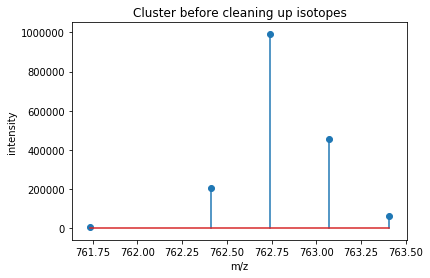

In [201]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster before cleaning up isotopes')
plt.show()

In [202]:
cluster_df.reset_index(drop=True, inplace=True)
base_peak_index = cluster_df.summed_intensity.idxmax()
cluster_df

,peak_id,mz_centroid,summed_intensity
0,5,761.736027,8133
1,2,762.413247,205885
2,1,762.741328,991466
3,3,763.073055,457446
4,4,763.405291,61030


In [203]:
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
PROTON_MASS = 1.007276  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [204]:
expected_spacing = DELTA_MZ / charge_state
expected_spacing

0.33445166666666665

In [205]:
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid
spacing_from_base = abs(cluster_df.mz_centroid - base_peak_mz) % expected_spacing
spacing_from_base

0    0.001945
1    0.328080
2    0.000000
3    0.331727
4    0.329512
Name: mz_centroid, dtype: float64

In [206]:
base_peak_mz

762.7413275396102

In [207]:
# drop indices that are not within 4*stddev of an isotope
std_dev = standard_deviation(base_peak_mz)
close_to_next_isotope = (abs(spacing_from_base - expected_spacing) < (standard_deviation(base_peak_mz) * 4))
close_to_next_isotope

0    False
1     True
2    False
3     True
4     True
Name: mz_centroid, dtype: bool

In [208]:
close_to_this_isotope = spacing_from_base < (standard_deviation(base_peak_mz) * 4)
close_to_this_isotope

0     True
1    False
2     True
3    False
4    False
Name: mz_centroid, dtype: bool

In [209]:
indexes_to_drop = ~(close_to_next_isotope | close_to_this_isotope)
indexes_to_drop

0    False
1    False
2    False
3    False
4    False
Name: mz_centroid, dtype: bool

In [210]:
cluster_df.drop(cluster_df.index[indexes_to_drop], inplace=True)
cluster_df.reset_index(drop=True, inplace=True)

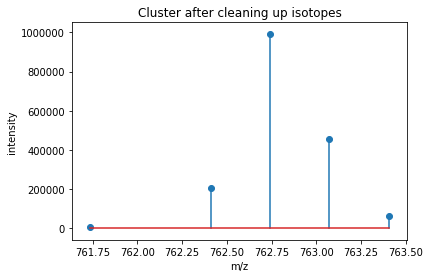

In [211]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster after cleaning up isotopes')
plt.show()

In [212]:
base_peak_index = cluster_df.summed_intensity.idxmax()
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid

In [213]:
indexes_to_drop = abs(cluster_df.mz_centroid.diff() - expected_spacing) > 0.5
indexes_to_drop

0    False
1    False
2    False
3    False
4    False
Name: mz_centroid, dtype: bool

In [214]:
cluster_df.drop(cluster_df.index[indexes_to_drop], inplace=True)
cluster_df.reset_index(drop=True, inplace=True)

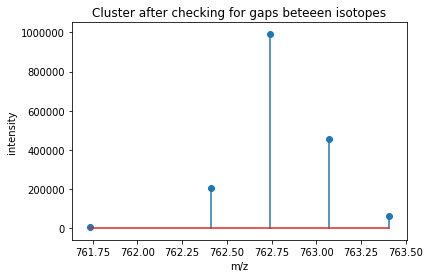

In [215]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster after checking for gaps beteeen isotopes')
plt.show()

In [216]:
# From "A Model-Based Method for the Prediction of the Isotopic Distribution of Peptides", Dirk Valkenborg, 
# Ivy Jansen, and Tomasz Burzykowski, J Am Soc Mass Spectrom 2008, 19, 703–712

MAX_NUMBER_OF_SULPHUR_ATOMS = 3
MAX_NUMBER_OF_PREDICTED_RATIOS = 6

S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S0_r[1] = [-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684]
S0_r[2] = [0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412]
S0_r[3] = [0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939]
S0_r[4] = [-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979]
S0_r[5] = [-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742]
S0_r[6] = [0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180]

S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S1_r[1] = [-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489]
S1_r[2] = [0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601]
S1_r[3] = [0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027]
S1_r[4] = [0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815]
S1_r[5] = [-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163]
S1_r[6] = [0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940]

S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S2_r[1] = [-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070]
S2_r[2] = [0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884]
S2_r[3] = [0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139]
S2_r[4] = [0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786]
S2_r[5] = [-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608]
S2_r[6] = [-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598]

model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=object)
model_params[0] = S0_r
model_params[1] = S1_r
model_params[2] = S2_r

# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    ratio = 0.0
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [217]:
# find the combination of mono index and sulphurs that gives the smallest total height ratio error
minimum_error = sys.float_info.max
minimum_error_sulphur = None
minimum_error_mono_index = None

for test_mono_index in range(0,base_peak_index+1):  # consider moving it up to the base peak (but not beyond)
    test_monoisotopic_mass = (cluster_df.loc[test_mono_index].mz_centroid - PROTON_MASS) * charge_state
    for sulphur in range(0,MAX_NUMBER_OF_SULPHUR_ATOMS):
        error = 0
        number_of_peaks_to_test = min(MAX_NUMBER_OF_PREDICTED_RATIOS, len(cluster_df)-test_mono_index)
        for peak_number in range(1,number_of_peaks_to_test):
            predicted_ratio = peak_ratio(test_monoisotopic_mass, peak_number=peak_number, number_of_sulphur=sulphur)
            if predicted_ratio > 0:
                observed_ratio = cluster_df.loc[test_mono_index+peak_number].summed_intensity / cluster_df.loc[test_mono_index+peak_number-1].summed_intensity
                error += (predicted_ratio - observed_ratio)**2 / predicted_ratio
            if error < minimum_error:
                minimum_error = error
                minimum_error_sulphur = sulphur
                minimum_error_mono_index = test_mono_index
monoisotopic_mass = (cluster_df.loc[minimum_error_mono_index].mz_centroid - PROTON_MASS) * feature_df.loc[0].charge_state
print("mono index: {}, sulphurs {}, monoisotopic mass {}, minimum error {}".format(minimum_error_mono_index, minimum_error_sulphur, monoisotopic_mass, minimum_error))

mono index: 2, sulphurs 2, monoisotopic mass 2285.20215462, minimum error 0.46939309396


In [218]:
cluster_df = cluster_df.loc[minimum_error_mono_index:].copy()

In [219]:
cluster_df.reset_index(drop=True, inplace=True)

In [220]:
cluster_df

,peak_id,mz_centroid,summed_intensity
0,1,762.741328,991466
1,3,763.073055,457446
2,4,763.405291,61030


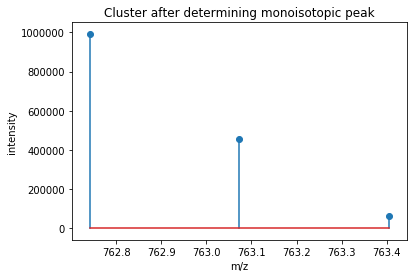

In [221]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.title('Cluster after determining monoisotopic peak')
plt.show()

In [222]:
expected_spacing

0.33445166666666665

In [223]:
cluster_df['mz_mod'] = cluster_df.mz_centroid - (cluster_df.index*expected_spacing)

In [224]:
cluster_df

,peak_id,mz_centroid,summed_intensity,mz_mod
0,1,762.741328,991466,762.741328
1,3,763.073055,457446,762.738603
2,4,763.405291,61030,762.736388


In [225]:
cluster_mz_centroid = wavg(cluster_df, "mz_mod", "summed_intensity")
cluster_mz_centroid

762.7403024449096

In [226]:
cluster_summed_intensity = cluster_df.summed_intensity.sum()
cluster_summed_intensity

1509942

In [227]:
monoisotopic_mass = (cluster_mz_centroid - PROTON_MASS) * charge_state
monoisotopic_mass

2285.1990793347286